# Završni projektni zadatak: Analiza podataka za smanjenje ugljičnog otiska Republike 
Cilj ovog zadatka je istražiti potencijal smanjenja ugljičnog otiska Republike Hrvatske optimiziranjem lokacija za postavljanje solarnih i vjetroelektrana na temelju dostupnih podataka o klimi.

Svrha zadatka je pokazati kako analizom podataka o klimatskim uvjetima (vjetrovi i osunčanost) možemo identificirati optimalne lokacije za obnovljive izvore energije i tako doprinijeti smanjenju emisija ugljičnog dioksida.

Autor: **Maksim Kos**

## Zadatak

1. **Prikupljanje podataka:**
    - Pronađite i preuzmite dostupne podatke o klimatskim uvjetima za Hrvatsku, fokusirajući se na vjetrove i osunčanost. Primjeri izvora podataka su:
        - [Podaci o klimi na meteo.hr](https://meteo.hr)
        - [Opis klime u Hrvatskoj na meteo.hr](https://meteo.hr)
        - PDF dokument na klima.hr
    - Pronađite podatke o emisijama ugljičnog dioksida za Republiku Hrvatsku kako biste mogli procijeniti utjecaj obnovljivih izvora energije.

2. **Izrada baze podataka:**
    - Kreirajte bazu podataka (SQLite) koja će sadržavati dvije tablice:
        - **klima**: podaci o vjetrovima i osunčanosti (lokacija, brzina vjetra, broj sunčanih sati, itd.).
        - **ugljik**: podaci o emisijama ugljičnog dioksida (godina, ukupna emisija, sektor).
    - Svaka tablica treba biti jasno definirana i sadržavati relevantne informacije.

3. **Analiza i integracija podataka:**
    - Implementirajte obradu podataka kako biste na temelju dostupnih informacija identificirali optimalne lokacije za postavljanje solarnih i vjetroelektrana.
    - Procijenite koliko bi se emisije ugljika smanjile ako bi se elektrane postavile na sve identificirane lokacije.

4. **Vizualizacija:**
    - Vizualizirajte klimatske podatke i lokacije elektrana pomoću modula GeoPandas ili sličnog alata.
    - Vizualizacije trebaju uključivati:
        - Lokacije s najboljim potencijalom za solarne i vjetroelektrane.
        - Klimatske uvjete (npr. vjetrovne karte, mape osunčanosti).
    - Osigurajte da vizualizacija bude interaktivna ili lako razumljiva.

5. **Zaključak:**
    - Baza podataka s prikupljenim i obrađenim podacima.
    - Jupyter Notebook radna bilježnica s dokumentacijom svih koraka obrade i analize podataka.
    - Vizualizacija podataka i konačni zaključci temeljeni na analizi.


## **NAPOMENA**
Preporučuje se korištenje modula poput pandas, matplotlib, GeoPandas, ili drugih relevantnih alata za analizu i vizualizaciju podataka. Prilikom preuzimanja podataka s mrežnih stranica možete koristiti alate poput `requests` i `BeautifulSoup` za automatizaciju.

Predajte projekt u obliku Jupyter Notebooka, uključujući dokumentaciju svih dijelova koda te zaključke temeljem analize. Pokažite kako analizom podataka možemo donijeti informirane odluke za bolju budućnost!

In [118]:
# Biblioteke
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as db
import numpy as np
import folium
from shapely.geometry import shape
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import time
import json


---

### 1. Prikupljanje podataka

#### Prikupljanje podataka o emisijama ugljučnog dioksida
- Izvor: https://www.worldometers.info/co2-emissions/croatia-co2-emissions/

In [119]:
# Postavke za headless browser
options = Options()
options.add_argument("--headless")
driver = webdriver.Chrome(options=options)

# Otvaranje stranice
url = "https://www.worldometers.info/co2-emissions/croatia-co2-emissions/"
driver.get(url)

# Čekanje učitavanja JS-a
time.sleep(3)

# Preuzimanje HTML-a nakon što se stranica učita
soup = BeautifulSoup(driver.page_source, 'html.parser')
driver.quit()  

# Traženje tablice
table = soup.find('table')

# Prikupljanje naziva stupaca
stupci = [th.text.strip() for th in table.find('thead').find_all('th')]

# Redovi
data = []
for red in table.find('tbody').find_all('tr'):
    cells = red.find_all('td')
    if len(cells) > 1:
        data.append([cell.text.strip() for cell in cells])

# Novi DataFrame
df_emisije_co2 = pd.DataFrame(data, columns=stupci)

# Ispis
print(df_emisije_co2.head())

   Year Fossil CO2emissions(tons) CO2 emissionschange CO2 emissionsper capita  \
0  2022                17,224,970               1.22%                    4.41   
1  2021                17,017,660               0.02%                    4.34   
2  2020                17,013,970              −5.14%                     4.3   
3  2019                17,935,050               1.29%                     4.5   
4  2018                17,707,470              −5.48%                     4.4   

  Population Pop.change Share of World'sCO2 emissions  
0  3,907,027     −0.45%                        0.045%  
1  3,924,610     −0.74%                        0.045%  
2  3,953,958     −0.81%                        0.047%  
3  3,986,334     −0.96%                        0.047%  
4  4,024,868     −1.33%                        0.047%  


In [120]:
# Ispis stupca iz df_emisije_co2
print(df_emisije_co2.columns)

Index(['Year', 'Fossil CO2emissions(tons)', 'CO2 emissionschange',
       'CO2 emissionsper capita', 'Population', 'Pop.change',
       'Share of World'sCO2 emissions'],
      dtype='object')


In [121]:
# Prevađanje na Hrvatski
df_emisije_co2.rename(columns={"Year": "Godina",
                               "Fossil CO2emissions(tons)": "Emisije fosilnog CO2 (tone)",
                               "CO2 emissionschange": "Promjena emisije CO2 (%)",
                               "CO2 emissionsper capita": "Emisije CO2 po glavi stanovnika",
                               "Population": "Stanovništvo",
                               "Pop.change": "Promjena stanovništva (%)",
                               "Share of World'sCO2 emissions": "Udio u svjetskim emisijama CO2 (%)"}, inplace=True)
df_emisije_co2.head()
# Ovdje je stavljen argument inplace=True zato jer radim izmjenu na postojećem DataFrame-u (ne vraćam novi objekt); U sličaju da sam stavio Fale, funkcija rename bi vratila novi DataFrame s promjenama

,Godina,Emisije fosilnog CO2 (tone),Promjena emisije CO2 (%),Emisije CO2 po glavi stanovnika,Stanovništvo,Promjena stanovništva (%),Udio u svjetskim emisijama CO2 (%)
0,2022,"17,224,970",1.22%,4.41,"3,907,027",−0.45%,0.045%
1,2021,"17,017,660",0.02%,4.34,"3,924,610",−0.74%,0.045%
2,2020,"17,013,970",−5.14%,4.3,"3,953,958",−0.81%,0.047%
3,2019,"17,935,050",1.29%,4.5,"3,986,334",−0.96%,0.047%
4,2018,"17,707,470",−5.48%,4.4,"4,024,868",−1.33%,0.047%


In [122]:
df_emisije_co2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Godina                              46 non-null     object
 1   Emisije fosilnog CO2 (tone)         46 non-null     object
 2   Promjena emisije CO2 (%)            46 non-null     object
 3   Emisije CO2 po glavi stanovnika     46 non-null     object
 4   Stanovništvo                        46 non-null     object
 5   Promjena stanovništva (%)           46 non-null     object
 6   Udio u svjetskim emisijama CO2 (%)  46 non-null     object
dtypes: object(7)
memory usage: 2.6+ KB


In [123]:
df_emisije_co2.head(5)

,Godina,Emisije fosilnog CO2 (tone),Promjena emisije CO2 (%),Emisije CO2 po glavi stanovnika,Stanovništvo,Promjena stanovništva (%),Udio u svjetskim emisijama CO2 (%)
0,2022,"17,224,970",1.22%,4.41,"3,907,027",−0.45%,0.045%
1,2021,"17,017,660",0.02%,4.34,"3,924,610",−0.74%,0.045%
2,2020,"17,013,970",−5.14%,4.3,"3,953,958",−0.81%,0.047%
3,2019,"17,935,050",1.29%,4.5,"3,986,334",−0.96%,0.047%
4,2018,"17,707,470",−5.48%,4.4,"4,024,868",−1.33%,0.047%


Zapisi u DataFrame-u su objekti, treba ih pretvoriti u brojeve kako bi se moglo raditi sa njima. Potrebno je ukloniti sve znakove ( , i %) pa zatim pretvoriti u numeričke varijable. Stupce koji predstavljaju postotak treba podijeliti sa 100 ( 5% -> 0.05)

In [124]:
df_emisije_co2['Emisije fosilnog CO2 (tone)'] = (
    df_emisije_co2['Emisije fosilnog CO2 (tone)']
    .astype(str)
    .str.replace(',', '')
    .astype('int64')
)

df_emisije_co2['Promjena emisije CO2 (%)'] = (
    df_emisije_co2['Promjena emisije CO2 (%)']
    .astype(str)
    .str.replace('%', '')
    .str.replace('–', '-')  
    .str.replace('−', '-')   
    .str.strip()
    .astype('float64') / 100
)

df_emisije_co2['Emisije CO2 po glavi stanovnika'] = (
    df_emisije_co2['Emisije CO2 po glavi stanovnika']
    .astype('float64')
)

df_emisije_co2['Stanovništvo'] = (
    df_emisije_co2['Stanovništvo']
    .astype(str)
    .str.replace(',', '')
    .astype('int64')
)

df_emisije_co2['Promjena stanovništva (%)'] = (
    df_emisije_co2['Promjena stanovništva (%)']
    .astype(str)
    .str.replace('%', '')
    .str.replace('–', '-') 
    .str.replace('−', '-') 
    .str.strip()
    .astype('float64') / 100
)

df_emisije_co2['Udio u svjetskim emisijama CO2 (%)'] = (
    df_emisije_co2['Udio u svjetskim emisijama CO2 (%)']
    .astype(str)
    .str.replace('%', '')
    .str.strip()
    .astype('float64') / 100
)
df_emisije_co2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Godina                              46 non-null     object 
 1   Emisije fosilnog CO2 (tone)         46 non-null     int64  
 2   Promjena emisije CO2 (%)            46 non-null     float64
 3   Emisije CO2 po glavi stanovnika     46 non-null     float64
 4   Stanovništvo                        46 non-null     int64  
 5   Promjena stanovništva (%)           46 non-null     float64
 6   Udio u svjetskim emisijama CO2 (%)  46 non-null     float64
dtypes: float64(4), int64(2), object(1)
memory usage: 2.6+ KB


In [125]:
df_emisije_co2.head()

,Godina,Emisije fosilnog CO2 (tone),Promjena emisije CO2 (%),Emisije CO2 po glavi stanovnika,Stanovništvo,Promjena stanovništva (%),Udio u svjetskim emisijama CO2 (%)
0,2022,17224970,0.0122,4.41,3907027,-0.0045,0.00045
1,2021,17017660,0.0002,4.34,3924610,-0.0074,0.00045
2,2020,17013970,-0.0514,4.30,3953958,-0.0081,0.00047
3,2019,17935050,0.0129,4.50,3986334,-0.0096,0.00047
4,2018,17707470,-0.0548,4.40,4024868,-0.0133,0.00047


Sada kada je tablica prevedena i zapisi u njoj su numeričkog tipa, može se sa njom raditi!

#### Prikupljanje podataka o emisijama ugljučnog dioksida po sektorima za svaku godinu (tone)
- Izvor podataka: https://www.worldometers.info/co2-emissions/croatia-co2-emissions/

Podaci na stranici su interaktivni, tj. za izradu grafikona korišten je JavaScript, te nije bilo moguće napraviti WebScraping. Stoga mi je ovdje pomogao ChatGPT.<br>
Salo sam mu slike, te na temlju njih, on je podatke sa tih slika pretvarao u riječnike koji će biti korišteni za izradu DataFrame-a.
- *"Jel ti mogu slati slike grafikona za pojedine godine, a ti ih pretvaraj u riječnike, koje ću koristiti da kreiram DataFrame"* - **JA**
<br><br>
- *"Naravno! Možeš mi slati slike grafikona za pojedine godine, a ja ću ih pretvarati u rječnike koje možeš koristiti za kreiranje DataFramea. Samo ih pošalji, pa ćemo krenuti!"* - **ChatGPT**

In [126]:
data_2006 = {
    "Godina": 2006,
    "Energetika": 5969430,
    "Poljoprivreda": 97640,
    "Industrijsko sagorijevanje": 3659360,
    "Transport": 6214300,
    "Zgrade": 3317600,
    "Eksploatacija goriva": 2059910,
    "Otpad": 430,
    "Procesi": 3089810
}

data_2007 = {
    "Godina": 2007,
    "Energetika": 5373390,
    "Poljoprivreda": 99000,
    "Industrijsko sagorijevanje": 3688280,
    "Transport": 6144560,
    "Zgrade": 3409240,
    "Eksploatacija goriva": 1550760,
    "Otpad": 440,
    "Procesi": 2956960
}

data_2008 = {
    "Godina": 2008,
    "Energetika": 4564120,
    "Poljoprivreda": 61440,
    "Industrijsko sagorijevanje": 3000720,
    "Transport": 6112640,
    "Zgrade": 3447570,
    "Eksploatacija goriva": 1940100,
    "Otpad": 110,
    "Procesi": 2445340
}

data_2009 = {
    "Godina": 2009,
    "Energetika": 4234580,
    "Poljoprivreda": 87370,
    "Industrijsko sagorijevanje": 2838090,
    "Transport": 5871590,
    "Zgrade": 3511910,
    "Eksploatacija goriva": 1795260,
    "Otpad": 30,
    "Procesi": 2488390
}

data_2010 = {
    "Godina": 2010,
    "Energetika": 4455410,
    "Poljoprivreda": 80140,
    "Industrijsko sagorijevanje": 2629920,
    "Transport": 5756760,
    "Zgrade": 3261970,
    "Eksploatacija goriva": 1844990,
    "Otpad": 30,
    "Procesi": 2308640
}

data_2011 = {
    "Godina": 2011,
    "Energetika": 4041780,
    "Poljoprivreda": 94290,
    "Industrijsko sagorijevanje": 2290220,
    "Transport": 5550430,
    "Zgrade": 2947620,
    "Eksploatacija goriva": 1553250,
    "Otpad": 60,
    "Procesi": 2214180
}

data_2012 = {
    "Godina": 2012,
    "Energetika": 3827160,
    "Poljoprivreda": 92710,
    "Industrijsko sagorijevanje": 2267240,
    "Transport": 5632430,
    "Zgrade": 2792280,
    "Eksploatacija goriva": 1370950,
    "Otpad": 30,
    "Procesi": 2323590
}

data_2013 = {
    "Godina": 2013,
    "Energetika": 3237490,
    "Poljoprivreda": 78570,
    "Industrijsko sagorijevanje": 2222300,
    "Transport": 5577130,
    "Zgrade": 2535870,
    "Eksploatacija goriva": 1458600,
    "Otpad": 30,
    "Procesi": 2510810
}

data_2014 = {
    "Godina": 2014,
    "Energetika": 3297330,
    "Poljoprivreda": 95860,
    "Industrijsko sagorijevanje": 2148480,
    "Transport": 5885330,
    "Zgrade": 2726870,
    "Eksploatacija goriva": 1392710,
    "Otpad": 30,
    "Procesi": 2415890
}

data_2015 = {
    "Godina": 2015,
    "Energetika": 3550030,
    "Poljoprivreda": 99000,
    "Industrijsko sagorijevanje": 2146040,
    "Transport": 6099740,
    "Zgrade": 2793140,
    "Eksploatacija goriva": 1238000,
    "Otpad": 30,
    "Procesi": 2282360
}

data_2016 = {
    "Godina": 2016,
    "Energetika": 3139770,
    "Poljoprivreda": 90510,
    "Industrijsko sagorijevanje": 2313350,
    "Transport": 6573080,
    "Zgrade": 2824700,
    "Eksploatacija goriva": 1284540,
    "Otpad": 0,
    "Procesi": 2508270
}

data_2017 = {
    "Godina": 2017,
    "Energetika": 2593240,
    "Poljoprivreda": 90200,
    "Industrijsko sagorijevanje": 2333650,
    "Transport": 6336500,
    "Zgrade": 2749290,
    "Eksploatacija goriva": 1254220,
    "Otpad": 0,
    "Procesi": 2350370
}

data_2018 = {
    "Godina": 2018,
    "Energetika": 2857270,
    "Poljoprivreda": 91300,
    "Industrijsko sagorijevanje": 2322250,
    "Transport": 6510660,
    "Zgrade": 2661090,
    "Eksploatacija goriva": 998970,
    "Otpad": 0,
    "Procesi": 2493510
}

data_2019 = {
    "Godina": 2019,
    "Energetika": 2845060,
    "Poljoprivreda": 98370,
    "Industrijsko sagorijevanje": 2333370,
    "Transport": 5705520,
    "Zgrade": 2729120,
    "Eksploatacija goriva": 815260,
    "Otpad": 0,
    "Procesi": 2487270
}

data_2020 = {
    "Godina": 2020,
    "Energetika": 2683820,
    "Poljoprivreda": 102370,
    "Industrijsko sagorijevanje": 2349040,
    "Transport": 6173730,
    "Zgrade": 2603820,
    "Eksploatacija goriva": 802340,
    "Otpad": 0,
    "Procesi": 2239890
}

data_2021 = {
    "Godina": 2021,
    "Energetika": 2522590,
    "Poljoprivreda": 106980,
    "Industrijsko sagorijevanje": 2370070,
    "Transport": 6654930,
    "Zgrade": 2661090,
    "Eksploatacija goriva": 798060,
    "Otpad": 0,
    "Procesi": 2168520
}

In [127]:
# Kreiranje DataFrame-a
df_emisije_co2_ukupno = pd.DataFrame([data_2006, data_2007, data_2008, data_2009, data_2010, data_2011,
                                      data_2012, data_2013, data_2014, data_2015, data_2016, data_2017,
                                      data_2018, data_2019, data_2020, data_2021])

# Dodavanje ukupne emisije
df_emisije_co2_ukupno["Ukupno"] = df_emisije_co2_ukupno[
    ["Energetika", "Poljoprivreda", "Industrijsko sagorijevanje", "Transport", 
     "Zgrade", "Eksploatacija goriva", "Otpad", "Procesi"]
].sum(axis=1)

df_emisije_co2_ukupno.head()

,Godina,Energetika,Poljoprivreda,Industrijsko sagorijevanje,Transport,Zgrade,Eksploatacija goriva,Otpad,Procesi,Ukupno
0,2006,5969430,97640,3659360,6214300,3317600,2059910,430,3089810,24408480
1,2007,5373390,99000,3688280,6144560,3409240,1550760,440,2956960,23222630
2,2008,4564120,61440,3000720,6112640,3447570,1940100,110,2445340,21572040
3,2009,4234580,87370,2838090,5871590,3511910,1795260,30,2488390,20827220
4,2010,4455410,80140,2629920,5756760,3261970,1844990,30,2308640,20337860


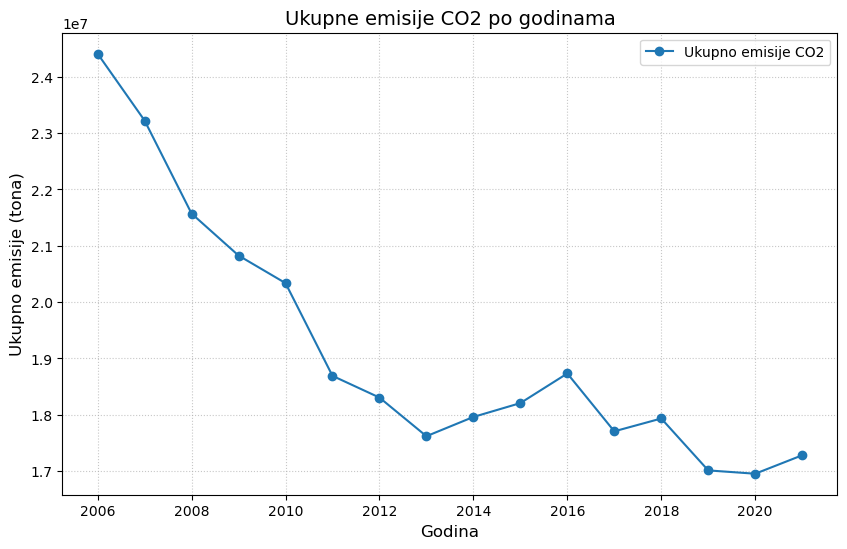

In [128]:
# Vizualizacija emisije po sektorima
plt.figure(figsize=(10, 6))
plt.plot(df_emisije_co2_ukupno["Godina"], df_emisije_co2_ukupno["Ukupno"], marker='o', label='Ukupno emisije CO2')

plt.title("Ukupne emisije CO2 po godinama", fontsize=14)
plt.xlabel("Godina", fontsize=12)
plt.ylabel("Ukupno emisije (tona)", fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.show()

Graf se usklađuje sa grafom na internetu, što znači da su podaci uspješno preneseni!

#### Prikupljanje podataka o osunčanosti
Sve slike preuzete su sa sljedeće stranice: https://abcgeografija.com/teme/insolacija/ <br>
Slika o županijama je preuzeta sa: https://www.kroatien-gastgeber.com/landkreise.html

Na žalost nisam uspio pronaći izvor na interneti gdje su podaci o osunčanost uneseni putem tablice, već jedino putem slika.<br>
Stoga sam i ovaj put koristio ChatGPT da mi uskrati vrijeme pretvaranja podataka sa slika:
- *"Jel ti mogu poslati sliku koja prikazuje srednju godišnju osunčanost u satima, te da na temelju slike, napraviš listu riječnika? Također, poslat ću ti i sliku koja pokazuje gdje se koja županija nalazi kako bi spremanje podataka bilo točnije"*  - **JA**
- *"Naravno, možete mi poslati slike koje prikazuju srednju godišnju osunčanost u satima i kartu koja jasno pokazuje gdje se nalazi svaka županija. Na temelju tih slika mogu generirati odgovarajući Python kod koji će sadržavati podatke o osunčanosti za svaku županiju, poput minimalne i maksimalne osunčanosti u satima, što će vam omogućiti daljnju analizu."* - **ChatGPT**


Slika koja prikazuje srednju godišnju osunčanost Hrvatske u satima:

![alt text](resources/images/sunlight_exposure.jpg)

Sa slike vidimo jasno vidimo razlike u bojama. Intenzivnija boja (crvena) označava veću osunčanost u satima.
- Kako bi analiza bila jednostavnija, napravit ću analizu po županijama, umjesto po gradovima

In [129]:
data_osuncanost = [
    {"Županija": "Istarska", "Osunčavanje (h)": 2400},
    {"Županija": "Primorsko-goranska", "Osunčavanje (h)": 2200},
    {"Županija": "Ličko-senjska", "Osunčavanje (h)": 2100},
    {"Županija": "Zadarska", "Osunčavanje (h)": 2500},
    {"Županija": "Šibensko-kninska", "Osunčavanje (h)": 2600},
    {"Županija": "Splitsko-dalmatinska", "Osunčavanje (h)": 2700},
    {"Županija": "Dubrovačko-neretvanska", "Osunčavanje (h)": 2700},
    {"Županija": "Karlovačka", "Osunčavanje (h)": 1800},
    {"Županija": "Krapinsko-zagorska", "Osunčavanje (h)": 1600},
    {"Županija": "Zagrebačka", "Osunčavanje (h)": 1650},
    {"Županija": "Osječko-baranjska", "Osunčavanje (h)": 1750},
    {"Županija": "Vukovarsko-srijemska", "Osunčavanje (h)": 1700},
    {"Županija": "Brodsko-posavska", "Osunčavanje (h)": 1700},
    {"Županija": "Virovitičko-podravska", "Osunčavanje (h)": 1700},
    {"Županija": "Koprivničko-križevačka", "Osunčavanje (h)": 1650},
    {"Županija": "Međimurska", "Osunčavanje (h)": 1600},
    {"Županija": "Varaždinska", "Osunčavanje (h)": 1600},
    {"Županija": "Sisačko-moslavačka", "Osunčavanje (h)": 1750},
    {"Županija": "Požeško-slavonska", "Osunčavanje (h)": 1750},
    {"Županija": "Bjelovarsko-bilogorska", "Osunčavanje (h)": 1700}
]


df_osuncanost = pd.DataFrame(data_osuncanost)
df_osuncanost.head()

,Županija,Osunčavanje (h)
0,Istarska,2400
1,Primorsko-goranska,2200
2,Ličko-senjska,2100
3,Zadarska,2500
4,Šibensko-kninska,2600


In [130]:
df_osuncanost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Županija         20 non-null     object
 1   Osunčavanje (h)  20 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 452.0+ bytes


Također, na stranici se nalazila i slika koja pokazuje podatke o ozračenosti. Nisam bio siguran jel su mi ti podaci potrebni za kasniju procjenu najboljih mjesta za postavljanje solarnih panela, stoga sam se konzultirao sa ChatGPT-jem:
- *"Jesu li podaci o ozračenosti potrebni za predviđanje najboljih lokacija za postavljanje sunčanih panela? Trenutno imam samo podatke o osunčavanju."* - **JA**
- *"Da, podaci o ozračenosti (količini sunčevog zračenja izraženoj u kWh/m²) su ključni za precizno predviđanje najboljih lokacija za postavljanje sunčanih panela. Iako podaci o osunčavanju (sati sunčeve svjetlosti godišnje) pružaju dobar uvid u potencijal lokacije, sami po sebi nisu dovoljni za tehničke i financijske procjene. Ozračenost izravno utječe na količinu proizvedene električne energije i omogućuje detaljnije izračune isplativosti i učinkovitosti solarnih panela. Stoga se preporučuje da, uz podatke o osunčavanju, prikupite i podatke o godišnjoj ozračenosti kako biste dobili potpuniju analizu."* - **ChatGPT**

Slika koja prikazuje ozracenost Hrvatske:

![alt text](resources/images/solar_radiation.jpg)

In [131]:
data_ozracenost = [
    {"Županija": "Istarska", "Min Ozračenost (kWh/m²)": 3.5, "Max Ozračenost (kWh/m²)": 3.8},
    {"Županija": "Primorsko-goranska", "Min Ozračenost (kWh/m²)": 3.4, "Max Ozračenost (kWh/m²)": 3.7},
    {"Županija": "Ličko-senjska", "Min Ozračenost (kWh/m²)": 3.8, "Max Ozračenost (kWh/m²)": 4.2},
    {"Županija": "Zadarska", "Min Ozračenost (kWh/m²)": 4.2, "Max Ozračenost (kWh/m²)": 4.5},
    {"Županija": "Šibensko-kninska", "Min Ozračenost (kWh/m²)": 4.3, "Max Ozračenost (kWh/m²)": 4.6},
    {"Županija": "Splitsko-dalmatinska", "Min Ozračenost (kWh/m²)": 4.4, "Max Ozračenost (kWh/m²)": 4.6},
    {"Županija": "Dubrovačko-neretvanska", "Min Ozračenost (kWh/m²)": 4.3, "Max Ozračenost (kWh/m²)": 4.6},
    {"Županija": "Karlovačka", "Min Ozračenost (kWh/m²)": 3.1, "Max Ozračenost (kWh/m²)": 3.4},
    {"Županija": "Krapinsko-zagorska", "Min Ozračenost (kWh/m²)": 2.7, "Max Ozračenost (kWh/m²)": 3.0},
    {"Županija": "Zagrebačka", "Min Ozračenost (kWh/m²)": 2.7, "Max Ozračenost (kWh/m²)": 3.0},
    {"Županija": "Osječko-baranjska", "Min Ozračenost (kWh/m²)": 3.1, "Max Ozračenost (kWh/m²)": 3.4},
    {"Županija": "Vukovarsko-srijemska", "Min Ozračenost (kWh/m²)": 3.1, "Max Ozračenost (kWh/m²)": 3.4},
    {"Županija": "Brodsko-posavska", "Min Ozračenost (kWh/m²)": 3.0, "Max Ozračenost (kWh/m²)": 3.3},
    {"Županija": "Virovitičko-podravska", "Min Ozračenost (kWh/m²)": 3.0, "Max Ozračenost (kWh/m²)": 3.3},
    {"Županija": "Koprivničko-križevačka", "Min Ozračenost (kWh/m²)": 2.7, "Max Ozračenost (kWh/m²)": 3.0},
    {"Županija": "Međimurska", "Min Ozračenost (kWh/m²)": 2.6, "Max Ozračenost (kWh/m²)": 2.9},
    {"Županija": "Varaždinska", "Min Ozračenost (kWh/m²)": 2.6, "Max Ozračenost (kWh/m²)": 2.9},
    {"Županija": "Sisačko-moslavačka", "Min Ozračenost (kWh/m²)": 3.0, "Max Ozračenost (kWh/m²)": 3.3},
    {"Županija": "Požeško-slavonska", "Min Ozračenost (kWh/m²)": 3.0, "Max Ozračenost (kWh/m²)": 3.3},
    {"Županija": "Bjelovarsko-bilogorska", "Min Ozračenost (kWh/m²)": 3.0, "Max Ozračenost (kWh/m²)": 3.3}
]

df_ozracenost = pd.DataFrame(data_ozracenost)
df_ozracenost["Prosječna Ozračenost (kWh/m²)"] = (df_ozracenost["Min Ozračenost (kWh/m²)"] + df_ozracenost["Max Ozračenost (kWh/m²)"]) / 2
df_ozracenost.head()

,Županija,Min Ozračenost (kWh/m²),Max Ozračenost (kWh/m²),Prosječna Ozračenost (kWh/m²)
0,Istarska,3.5,3.8,3.65
1,Primorsko-goranska,3.4,3.7,3.55
2,Ličko-senjska,3.8,4.2,4.00
3,Zadarska,4.2,4.5,4.35
4,Šibensko-kninska,4.3,4.6,4.45


In [132]:
df_ozracenost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Županija                       20 non-null     object 
 1   Min Ozračenost (kWh/m²)        20 non-null     float64
 2   Max Ozračenost (kWh/m²)        20 non-null     float64
 3   Prosječna Ozračenost (kWh/m²)  20 non-null     float64
dtypes: float64(3), object(1)
memory usage: 772.0+ bytes


##### Provjera podataka

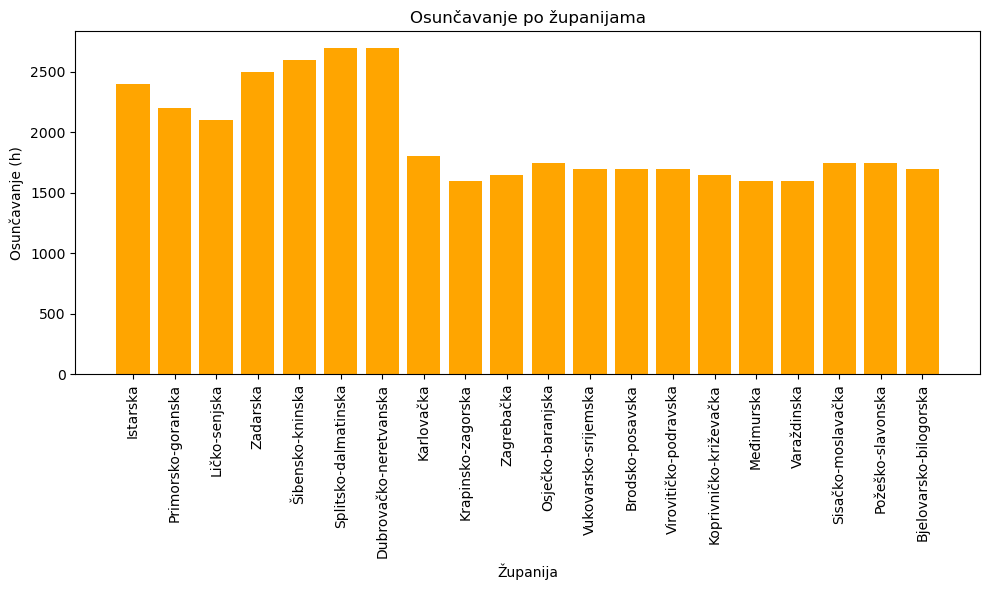

In [133]:
#Provjera podataka za osunčanost
zupanije = [zupanija["Županija"] for zupanija in data_osuncanost]
osuncanost = [item["Osunčavanje (h)"] for item in data_osuncanost]

# Vizualizacija
plt.figure(figsize=(10, 6))
plt.bar(zupanije, osuncanost, color="orange")
plt.xticks(rotation=90)
plt.xlabel("Županija")
plt.ylabel("Osunčavanje (h)")
plt.title("Osunčavanje po županijama")
plt.tight_layout()
plt.show()


Uspoređujući dobiveni graf i kartu osuncanosti, mogu zaključiti da su podaci dobro prebačeni!<br>
Najveću osunčanost imaju županije:
- Splitsko - Dalmatinska
- Dubrovačko - Neretvanska
- Šibensko - Kninska
- Zadarska
- Istarska

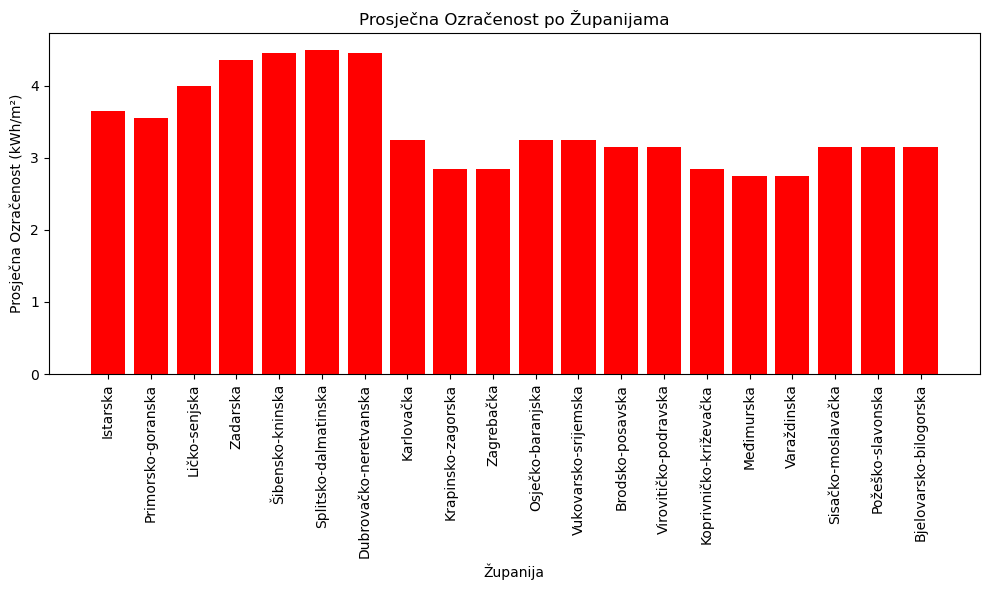

In [134]:
#Provjera podataka za ozračenost
zupanije = df_ozracenost["Županija"]
ozracenost = df_ozracenost["Prosječna Ozračenost (kWh/m²)"]

# Vizualizacija
plt.figure(figsize=(10, 6))
plt.bar(zupanije, ozracenost, color="red")
plt.xticks(rotation=90)
plt.xlabel("Županija")
plt.ylabel("Prosječna Ozračenost (kWh/m²)")
plt.title("Prosječna Ozračenost po Županijama")
plt.tight_layout()
plt.show()

Sa grafa vidimo kako najveću prosječnu ozračenost imaju županije:
- Zadarska,
- Šibensko - Kninska,
- Splitsko - Dalmatinska 
- Dubrovačko - Neretvanska

Ove županije su na krati ozračenosti označene sa crvenom bojom što predstavlja veliku ozračenost. Stoga su i podaci o ozračenosti uspješno prikupljeni.

#### Prikupljanje podataka o brzini i snazi vjetra
Preuzeto sa: https://meteo.hr/klima.php?section=klima_hrvatska&param=k1_8

Navedena stranica sadrži 4 slike koje predstavljaju srednje godišnje brzine i snage vjetra. Dostupni su podaci o vjetru koji se nalazi na visini 10m iznad tla, te na visini 80m iznad tla. Kako su vjetrenjače dosta više od 10m, (bliže 80m nego 10m), koristiti ću podatke za 80m. Također, podaci su prikupljeni pomocu ChatGPT-a, kao i za ozračenost i osunčanost. Također, nisam bio siguran jesu li mi potrebne informacije o srednjoj gustoći snage vjetra, stoga sam se konzultirao sa Chatom:
- *"Kako bih procjenio idealno mjesto za vjetrenjače u Hrvatskoj, jesu li mi potrebni podaci od srednjoj godišnjoj gustoći snage vjetra uz srednje godišnje brzine vjetra? Također, koja je razlika izmeću tih dviju informacija?"* - **JA**
- *"Srednja godišnja gustoća snage vjetra i srednje godišnje brzine vjetra su obje ključne informacije za procjenu idealnih mjesta za postavljanje vjetrenjača u Hrvatskoj. Brzina vjetra daje osnovnu informaciju o tome koliko je područje vjetrovito, ali sama brzina nije dovoljna jer energija vjetra raste s trećom potencijom brzine (E ∝ v³). S druge strane, gustoća snage vjetra predstavlja direktnu energetsku vrijednost vjetra na određenoj visini i ovisi ne samo o brzini vjetra, već i o gustoći zraka. Stoga, gustoća snage vjetra daje točniju procjenu potencijala područja za proizvodnju energije i ključna je za izbor lokacije vjetrenjače. U kombinaciji s podacima o brzini vjetra, omogućava detaljniju analizu kako bi se identificirale optimalne lokacije."* - **ChatGPT**

In [135]:
# Podaci o prosječnoj brzini vjetra
data_brzina_vjetra = [
    {"Županija": "Istarska", "Min Brzina vjetra (m/s)": 4.0, "Max Brzina vjetra (m/s)": 4.5, "Prosjek Brzine vjetra (m/s)": 4.25},
    {"Županija": "Splitsko-dalmatinska", "Min Brzina vjetra (m/s)": 7.0, "Max Brzina vjetra (m/s)": 7.5, "Prosjek Brzine vjetra (m/s)": 7.00},
    {"Županija": "Ličko-senjska", "Min Brzina vjetra (m/s)": 6.0, "Max Brzina vjetra (m/s)": 10.0, "Prosjek Brzine vjetra (m/s)": 8.00},
    {"Županija": "Zadarska", "Min Brzina vjetra (m/s)": 7.0, "Max Brzina vjetra (m/s)": 8.0, "Prosjek Brzine vjetra (m/s)": 7.50},
    {"Županija": "Šibensko-kninska", "Min Brzina vjetra (m/s)": 7.0, "Max Brzina vjetra (m/s)": 7.5, "Prosjek Brzine vjetra (m/s)": 7.25},
    {"Županija": "Primorsko-goranska", "Min Brzina vjetra (m/s)": 7.5, "Max Brzina vjetra (m/s)": 8.0, "Prosjek Brzine vjetra (m/s)": 7.75},
    {"Županija": "Dubrovačko-neretvanska", "Min Brzina vjetra (m/s)": 7.0, "Max Brzina vjetra (m/s)": 7.5, "Prosjek Brzine vjetra (m/s)": 7.25},
    {"Županija": "Karlovačka", "Min Brzina vjetra (m/s)": 3.5, "Max Brzina vjetra (m/s)": 4.0, "Prosjek Brzine vjetra (m/s)": 3.75},
    {"Županija": "Bjelovarsko-bilogorska", "Min Brzina vjetra (m/s)": 2.0, "Max Brzina vjetra (m/s)": 2.5, "Prosjek Brzine vjetra (m/s)": 2.25},
    {"Županija": "Zagrebačka", "Min Brzina vjetra (m/s)": 2.0, "Max Brzina vjetra (m/s)": 2.5, "Prosjek Brzine vjetra (m/s)": 2.25},
    {"Županija": "Krapinsko-zagorska", "Min Brzina vjetra (m/s)": 2.0, "Max Brzina vjetra (m/s)": 2.5, "Prosjek Brzine vjetra (m/s)": 2.25},
    {"Županija": "Varaždinska", "Min Brzina vjetra (m/s)": 1.5, "Max Brzina vjetra (m/s)": 2.0, "Prosjek Brzine vjetra (m/s)": 1.75},
    {"Županija": "Koprivničko-križevačka", "Min Brzina vjetra (m/s)": 2.0, "Max Brzina vjetra (m/s)": 2.5, "Prosjek Brzine vjetra (m/s)": 2.25},
    {"Županija": "Međimurska", "Min Brzina vjetra (m/s)": 1.5, "Max Brzina vjetra (m/s)": 2.0, "Prosjek Brzine vjetra (m/s)": 1.75},
    {"Županija": "Virovitičko-podravska", "Min Brzina vjetra (m/s)": 2.5, "Max Brzina vjetra (m/s)": 3.0, "Prosjek Brzine vjetra (m/s)": 2.75},
    {"Županija": "Osječko-baranjska", "Min Brzina vjetra (m/s)": 3.0, "Max Brzina vjetra (m/s)": 3.5, "Prosjek Brzine vjetra (m/s)": 3.25},
    {"Županija": "Brodsko-posavska", "Min Brzina vjetra (m/s)": 3.0, "Max Brzina vjetra (m/s)": 3.5, "Prosjek Brzine vjetra (m/s)": 3.25},
    {"Županija": "Požeško-slavonska", "Min Brzina vjetra (m/s)": 3.0, "Max Brzina vjetra (m/s)": 3.5, "Prosjek Brzine vjetra (m/s)": 3.25},
    {"Županija": "Sisačko-moslavačka", "Min Brzina vjetra (m/s)": 3.5, "Max Brzina vjetra (m/s)": 4.0, "Prosjek Brzine vjetra (m/s)": 3.75},
    {"Županija": "Vukovarsko-srijemska", "Min Brzina vjetra (m/s)": 3.0, "Max Brzina vjetra (m/s)": 3.5, "Prosjek Brzine vjetra (m/s)": 3.25}
    
]

df_brzina_vjetra = pd.DataFrame(data_brzina_vjetra)
df_brzina_vjetra = df_brzina_vjetra.sort_values(by="Prosjek Brzine vjetra (m/s)", ascending=False)
df_brzina_vjetra.head()

,Županija,Min Brzina vjetra (m/s),Max Brzina vjetra (m/s),Prosjek Brzine vjetra (m/s)
2,Ličko-senjska,6.0,10.0,8.00
5,Primorsko-goranska,7.5,8.0,7.75
3,Zadarska,7.0,8.0,7.50
4,Šibensko-kninska,7.0,7.5,7.25
6,Dubrovačko-neretvanska,7.0,7.5,7.25


In [136]:
df_brzina_vjetra.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 2 to 11
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Županija                     20 non-null     object 
 1   Min Brzina vjetra (m/s)      20 non-null     float64
 2   Max Brzina vjetra (m/s)      20 non-null     float64
 3   Prosjek Brzine vjetra (m/s)  20 non-null     float64
dtypes: float64(3), object(1)
memory usage: 800.0+ bytes


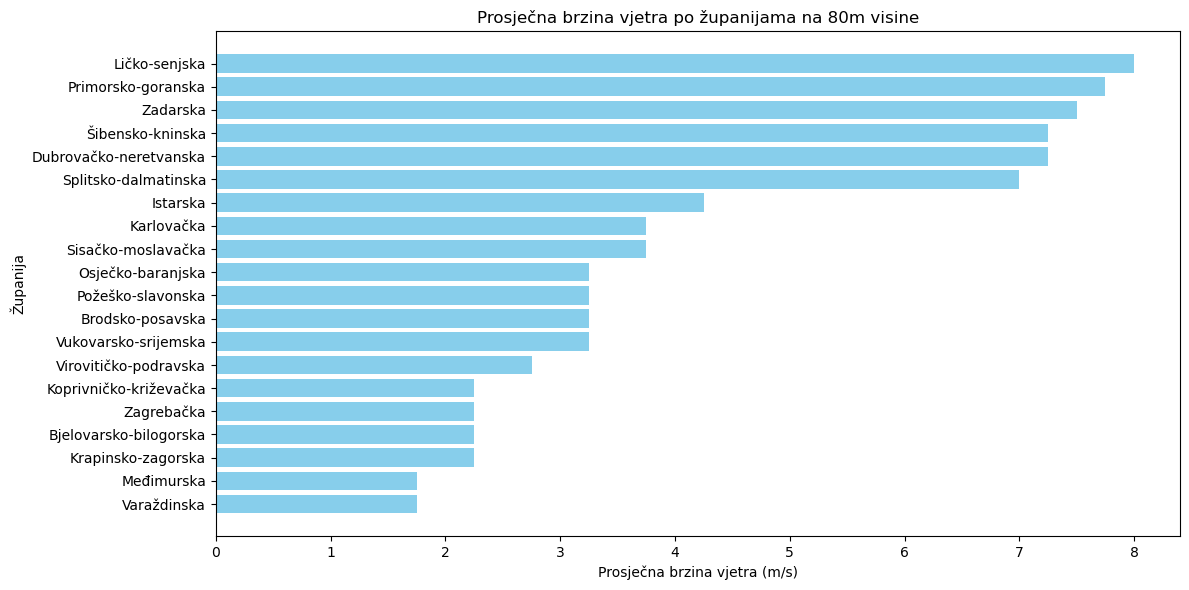

In [137]:
# Vizualizacija
plt.figure(figsize=(12,6))
plt.barh(df_brzina_vjetra["Županija"], df_brzina_vjetra["Prosjek Brzine vjetra (m/s)"], color='skyblue')
plt.xlabel("Prosječna brzina vjetra (m/s)")
plt.ylabel("Županija")
plt.title("Prosječna brzina vjetra po županijama na 80m visine")
plt.gca().invert_yaxis()  # Inverzija reda za bolje čitanje
plt.tight_layout()
plt.show()

Najveće brzine vjetra na visini od 80 m iznad tla imaju sljedeće županije:
- Ličko - Senjska
- Primorsko - Ogranska
- Zadarska
- Šibensko - Kninska
- Dubrovačko Neretvanska
- Splitsko - Dalmatinska

Ovi rezultati se poklapaju sa županijama na karti koja prikazuje srednje godisnje brzine vjetrova.

In [138]:
# Prikupljanje podataka za snagu vjetra
data_gustoca_snage_vjetra = [
    {"Županija": "Istarska", "Min Gustoća snage (W/m²)": 250, "Max Gustoća snage (W/m²)": 450, "Prosjek Gustoće snage (W/m²)": 350},
    {"Županija": "Zadarska", "Min Gustoća snage (W/m²)": 900, "Max Gustoća snage (W/m²)": 1100, "Prosjek Gustoće snage (W/m²)": 1000},
    {"Županija": "Ličko-senjska", "Min Gustoća snage (W/m²)": 1100, "Max Gustoća snage (W/m²)": 1350, "Prosjek Gustoće snage (W/m²)": 1225},
    {"Županija": "Primorsko-goranska", "Min Gustoća snage (W/m²)": 1000, "Max Gustoća snage (W/m²)": 1250, "Prosjek Gustoće snage (W/m²)": 1125},
    {"Županija": "Šibensko-kninska", "Min Gustoća snage (W/m²)": 900, "Max Gustoća snage (W/m²)": 1100, "Prosjek Gustoće snage (W/m²)": 1000},
    {"Županija": "Splitsko-dalmatinska", "Min Gustoća snage (W/m²)": 850, "Max Gustoća snage (W/m²)": 1050, "Prosjek Gustoće snage (W/m²)": 950},
    {"Županija": "Dubrovačko-neretvanska", "Min Gustoća snage (W/m²)": 850, "Max Gustoća snage (W/m²)": 1050, "Prosjek Gustoće snage (W/m²)": 950},
    {"Županija": "Karlovačka", "Min Gustoća snage (W/m²)": 250, "Max Gustoća snage (W/m²)": 400, "Prosjek Gustoće snage (W/m²)": 325},
    {"Županija": "Bjelovarsko-bilogorska", "Min Gustoća snage (W/m²)": 200, "Max Gustoća snage (W/m²)": 300, "Prosjek Gustoće snage (W/m²)": 250},
    {"Županija": "Zagrebačka", "Min Gustoća snage (W/m²)": 200, "Max Gustoća snage (W/m²)": 300, "Prosjek Gustoće snage (W/m²)": 250},
    {"Županija": "Krapinsko-zagorska", "Min Gustoća snage (W/m²)": 150, "Max Gustoća snage (W/m²)": 250, "Prosjek Gustoće snage (W/m²)": 200},
    {"Županija": "Varaždinska", "Min Gustoća snage (W/m²)": 100, "Max Gustoća snage (W/m²)": 200, "Prosjek Gustoće snage (W/m²)": 150},
    {"Županija": "Koprivničko-križevačka", "Min Gustoća snage (W/m²)": 150, "Max Gustoća snage (W/m²)": 250, "Prosjek Gustoće snage (W/m²)": 200},
    {"Županija": "Međimurska", "Min Gustoća snage (W/m²)": 100, "Max Gustoća snage (W/m²)": 200, "Prosjek Gustoće snage (W/m²)": 150},
    {"Županija": "Virovitičko-podravska", "Min Gustoća snage (W/m²)": 200, "Max Gustoća snage (W/m²)": 300, "Prosjek Gustoće snage (W/m²)": 250},
    {"Županija": "Osječko-baranjska", "Min Gustoća snage (W/m²)": 250, "Max Gustoća snage (W/m²)": 400, "Prosjek Gustoće snage (W/m²)": 325},
    {"Županija": "Brodsko-posavska", "Min Gustoća snage (W/m²)": 250, "Max Gustoća snage (W/m²)": 400, "Prosjek Gustoće snage (W/m²)": 325},
    {"Županija": "Požeško-slavonska", "Min Gustoća snage (W/m²)": 300, "Max Gustoća snage (W/m²)": 450, "Prosjek Gustoće snage (W/m²)": 375},
    {"Županija": "Sisačko-moslavačka", "Min Gustoća snage (W/m²)": 300, "Max Gustoća snage (W/m²)": 450, "Prosjek Gustoće snage (W/m²)": 375},
    {"Županija": "Vukovarsko-srijemska", "Min Gustoća snage (W/m²)": 200, "Max Gustoća snage (W/m²)": 300, "Prosjek Gustoće snage (W/m²)": 250}
]


df_gustoca_snage_vjetra = pd.DataFrame(data_gustoca_snage_vjetra)
df_gustoca_snage_vjetra = df_gustoca_snage_vjetra.sort_values(by="Prosjek Gustoće snage (W/m²)", ascending=True)
df_gustoca_snage_vjetra.head()

,Županija,Min Gustoća snage (W/m²),Max Gustoća snage (W/m²),Prosjek Gustoće snage (W/m²)
13,Međimurska,100,200,150
11,Varaždinska,100,200,150
12,Koprivničko-križevačka,150,250,200
10,Krapinsko-zagorska,150,250,200
9,Zagrebačka,200,300,250


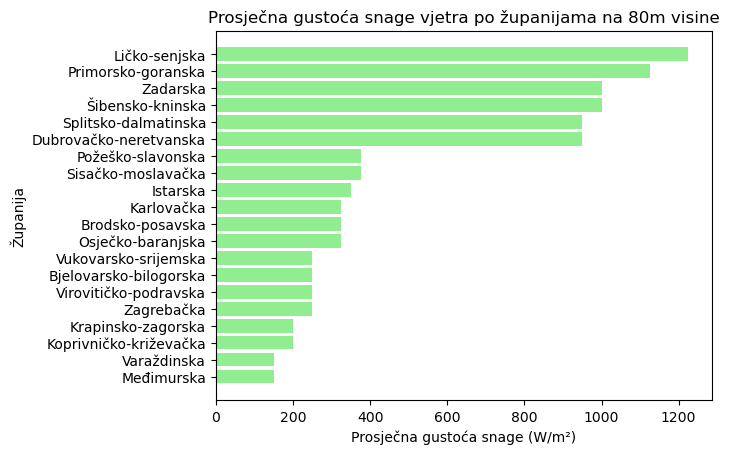

In [139]:
# Vizualizacija
plt.barh(df_gustoca_snage_vjetra["Županija"], df_gustoca_snage_vjetra["Prosjek Gustoće snage (W/m²)"], color='lightgreen')
plt.xlabel("Prosječna gustoća snage (W/m²)")
plt.ylabel("Županija")
plt.title("Prosječna gustoća snage vjetra po županijama na 80m visine")
plt.show()

Podaci su usklađeni sa kartom i sa podacima o srednjoj godišnjoj brzini vjetra za pojedinu županiju.

Sada kada su svi potrebni podaci uneseni, mogu krenuti sa izradom baze podataka.

---

### 2. Izrada baze podataka

Kako bih se upoznao sa sqlite3 bibliotekom, koristio sam sljedeće izvore:
- https://www.youtube.com/watch?v=girsuXz0yA8
- https://www.youtube.com/watch?v=5LpotBtmZZs

In [140]:
# Kreiranje baze
connection = db.connect('data/project_data.db')

In [141]:
# Kreiranje kursora -> omogućuje izvršavanje SQL upita
cur = connection.cursor()

In [142]:
# Provjera podataka prije unosa u tablicu
print(df_osuncanost.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Županija         20 non-null     object
 1   Osunčavanje (h)  20 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 452.0+ bytes
None


In [143]:
print(df_ozracenost.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Županija                       20 non-null     object 
 1   Min Ozračenost (kWh/m²)        20 non-null     float64
 2   Max Ozračenost (kWh/m²)        20 non-null     float64
 3   Prosječna Ozračenost (kWh/m²)  20 non-null     float64
dtypes: float64(3), object(1)
memory usage: 772.0+ bytes
None


In [144]:
print(df_brzina_vjetra.info())

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 2 to 11
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Županija                     20 non-null     object 
 1   Min Brzina vjetra (m/s)      20 non-null     float64
 2   Max Brzina vjetra (m/s)      20 non-null     float64
 3   Prosjek Brzine vjetra (m/s)  20 non-null     float64
dtypes: float64(3), object(1)
memory usage: 800.0+ bytes
None


In [145]:
print(df_gustoca_snage_vjetra.info())

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 13 to 2
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Županija                      20 non-null     object
 1   Min Gustoća snage (W/m²)      20 non-null     int64 
 2   Max Gustoća snage (W/m²)      20 non-null     int64 
 3   Prosjek Gustoće snage (W/m²)  20 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 800.0+ bytes
None


Sada kada znam kojeg su tipa koji stupci iz pojedinih tablica, mogu krenuti sa izradom tablica

In [146]:
# Spajanje glavnih stupca iz svakog DataFrame-a u jedan DataFrame kako bi unos podataka bio jednostavniji - Spajanje podataka prema stupcu Županija
df_klima = df_osuncanost.merge(df_ozracenost[["Županija", "Prosječna Ozračenost (kWh/m²)"]], on="Županija", how="inner")
df_klima = df_klima.merge(df_brzina_vjetra[["Županija", "Prosjek Brzine vjetra (m/s)"]], on="Županija", how="inner")
df_klima = df_klima.merge(df_gustoca_snage_vjetra[["Županija", "Prosjek Gustoće snage (W/m²)"]], on="Županija", how="inner")

print(df_klima.head())

             Županija  Osunčavanje (h)  Prosječna Ozračenost (kWh/m²)  \
0            Istarska             2400                           3.65   
1  Primorsko-goranska             2200                           3.55   
2       Ličko-senjska             2100                           4.00   
3            Zadarska             2500                           4.35   
4    Šibensko-kninska             2600                           4.45   

   Prosjek Brzine vjetra (m/s)  Prosjek Gustoće snage (W/m²)  
0                         4.25                           350  
1                         7.75                          1125  
2                         8.00                          1225  
3                         7.50                          1000  
4                         7.25                          1000  


In [147]:
# Provjera podataka:
df_klima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Županija                       20 non-null     object 
 1   Osunčavanje (h)                20 non-null     int64  
 2   Prosječna Ozračenost (kWh/m²)  20 non-null     float64
 3   Prosjek Brzine vjetra (m/s)    20 non-null     float64
 4   Prosjek Gustoće snage (W/m²)   20 non-null     int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 932.0+ bytes


In [148]:
kreiranje_tablice_klima = """CREATE TABLE IF NOT EXISTS klima
                (zupanija_id INTEGER PRIMARY KEY AUTOINCREMENT,
                zupanija TEXT NOT NULL,
                osuncanost_h INTEGER NOT NULL,
                prosjecna_ozracenost_kwh_m2 FLOAT NOT NULL,
                prosjek_brzine_vjetra_ms FLOAT NOT NULL,
                prosjek_gustoca_snage_w_m2 INTEGER NOT NULL);"""

cur.execute(kreiranje_tablice_klima)

In [149]:
# Unos podataka
df_klima.to_sql("klima", connection, if_exists="replace", index=False)

20

In [150]:
df_provjera1 = pd.read_sql_query("select * from klima", connection)
df_provjera1

,Županija,Osunčavanje (h),Prosječna Ozračenost (kWh/m²),Prosjek Brzine vjetra (m/s),Prosjek Gustoće snage (W/m²)
0,Istarska,2400,3.65,4.25,350
1,Primorsko-goranska,2200,3.55,7.75,1125
2,Ličko-senjska,2100,4.00,8.00,1225
3,Zadarska,2500,4.35,7.50,1000
4,Šibensko-kninska,2600,4.45,7.25,1000
5,Splitsko-dalmatinska,2700,4.50,7.00,950
6,Dubrovačko-neretvanska,2700,4.45,7.25,950
7,Karlovačka,1800,3.25,3.75,325
8,Krapinsko-zagorska,1600,2.85,2.25,200
9,Zagrebačka,1650,2.85,2.25,250


In [151]:
# Provjera podataka
df_emisije_co2_ukupno.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   Godina                      16 non-null     int64
 1   Energetika                  16 non-null     int64
 2   Poljoprivreda               16 non-null     int64
 3   Industrijsko sagorijevanje  16 non-null     int64
 4   Transport                   16 non-null     int64
 5   Zgrade                      16 non-null     int64
 6   Eksploatacija goriva        16 non-null     int64
 7   Otpad                       16 non-null     int64
 8   Procesi                     16 non-null     int64
 9   Ukupno                      16 non-null     int64
dtypes: int64(10)
memory usage: 1.4 KB


In [152]:
kreiranje_tablice_ugljik = """CREATE TABLE IF NOT EXISTS ugljik (
                godina INTEGER PRIMARY KEY,
                energetika INTEGER NOT NULL,
                poljoprivreda INTEGER NOT NULL,
                industrijsko_sagorijevanje INTEGER NOT NULL,
                transport INTEGER NOT NULL,
                zgrade INTEGER NOT NULL,
                eksploatacija_goriva INTEGER NOT NULL,
                otpad INTEGER NOT NULL,
                procesi INTEGER NOT NULL,
                ukupno INTEGER NOT NULL);"""

cur.execute(kreiranje_tablice_ugljik)

In [153]:
# Unos podataka
df_emisije_co2_ukupno.to_sql("ugljik", connection, if_exists="replace", index=False)

16

In [154]:
df_provjera2 = pd.read_sql_query("select * from ugljik", connection)
df_provjera2

,Godina,Energetika,Poljoprivreda,Industrijsko sagorijevanje,Transport,Zgrade,Eksploatacija goriva,Otpad,Procesi,Ukupno
0,2006,5969430,97640,3659360,6214300,3317600,2059910,430,3089810,24408480
1,2007,5373390,99000,3688280,6144560,3409240,1550760,440,2956960,23222630
2,2008,4564120,61440,3000720,6112640,3447570,1940100,110,2445340,21572040
3,2009,4234580,87370,2838090,5871590,3511910,1795260,30,2488390,20827220
4,2010,4455410,80140,2629920,5756760,3261970,1844990,30,2308640,20337860
5,2011,4041780,94290,2290220,5550430,2947620,1553250,60,2214180,18691830
6,2012,3827160,92710,2267240,5632430,2792280,1370950,30,2323590,18306390
7,2013,3237490,78570,2222300,5577130,2535870,1458600,30,2510810,17620800
8,2014,3297330,95860,2148480,5885330,2726870,1392710,30,2415890,17962500
9,2015,3550030,99000,2146040,6099740,2793140,1238000,30,2282360,18208340


In [155]:
# Na kraju je potrebno zatvoriti vezu kursor i konekciju
cur.close()
connection.close()

---

### 3. Analiza i integracija podataka
- M. Medvidović, "Optimiranje samostalnog hibridnog sustava," diplomski rad, Fakultet elektrotehnike i računarstva, Sveučilište u Zagrebu, Zagreb, lipanj 2010.
    - https://www.ieee.hr/_download/repository/ZR10MMedvidovic.pdf
- L. Kadi, "Koncept sustava za proizvodnju zelenog vodika uporabom energije vjetra," diplomski rad, Tehnički fakultet, Sveučilište u Rijeci, Rijeka, rujan 2022.
    - https://www.unirepository.svkri.uniri.hr/islandora/object/riteh:3404
- Renewables First - Wind turbine funcamentals
    - https://renewablesfirst.co.uk/renewable-energy-technologies/windpower/windpower-learning-centre/wind-turbine-fundamentals/
- Boston Solar, "How Much CO2 Do Solar Panels Save?", 15. srpanj 2024.
    - https://www.bostonsolar.us/solar-blog-resource-center/blog/how-much-co2-do-solar-panels-save/
- *"Most residential solar panes on today's market are rated to produce between 250 and 400 watts each per hour."* ->YES energy solutions, "How much energy do solar panels produce for your home"
    - https://www.yesenergysolutions.co.uk/advice/how-much-energy-solar-panels-produce-home#:~:text=Most%20residential%20solar%20panels%20on,1%20kW%20and%204%20kW
- *"The transmission and generation (T&D) emissions factor for grdid electricity has increased from 2023 ... to 0.01830 kg CO2 per kWh."* -> BusinessEnergyScotland, "How to calculate your business's carbon footprint"
    - https://businessenergyscotland.org/guides/how-calculate-your-businesss-carbon-footprint/#:~:text=For%20electricity%2C%20the%20calculation%20will,1%2C000%20%3D%203.7tCO2e
- *"It is reckoned that an average onshore wind turbine rated at 2.5 - 3 megawatts can produce in excess of 6 million kWh every year."* -> InspireCleanEnergy, "How Much Power Does A Wind Turbine Produce?"
    - https://www.inspirecleanenergy.com/blog/clean-energy-101/how-much-energy-does-wind-turbine-produce


M. Medvidović u svojem diplomskom radu navodi da je za vjetrenjaču za idealnu proizvodnju električne energije bila potrebna brzina vjetra od oko 12m/s. Isto tako navodi sljedeće: *"Minimalna srednja godišnja brzina vjetra pri kojoj je isplativo izgraditi vjetroelektranu, odnosno donja granica korisnog rada vjetroelektrane je između 4 i 5 m/s."*

L. Kadi u svojem diplomskom radu navodi sljedeće: *"Najveći utjecaj na snagu vjetra ima brzina vjetra. Međutim, ni jedna vjetroturbina ne može pretvoriti svu kinetičku energiju vjetra u mehaničku energiju na lopaticama rotora. O tome govori Betzovo pravilo, prema kojem se maksimalno 59,3 % kinetičke energije vjetra može pretvoriti u korisnu mehaničku energiju"*<br><br>


Nisam uspio pronaći konkretne informacije o potrebnoj srednjoj gustoći snage vjetra, te i koliki je optimalan broj vjetrenjača da se postavi, stoga sam se konzultirao sa ChatGPT-jem:
- *"Kolika bi srednja godišnja gustoća snage vjetra bila potrebna da bi bilo isplativo postaviti vjetrenjaču, te koliki bi bio optimalan broj vjetrenjača da se u čim bržem roku pokaže isplativost projekta?"* - **JA**
- *"Za postavljanje vjetrenjače potrebno je da srednja godišnja gustoća snage vjetra iznosi najmanje 300 W/m² kako bi projekt bio ekonomski isplativ. Optimalan broj vjetrenjača ovisi o veličini područja, raspoloživim financijskim sredstvima i ciljevima projekta, no često se smatra da se početni povrat ulaganja može postići s 10-20 vjetrenjača na lokacijama s povoljnim uvjetima, pri čemu svaka vjetroturbina može proizvesti između 1-3 MW električne energije, ovisno o tipu i modelu."* - **ChatGPT**

Renewables First navodi: *"Bilo koja lokacija sa srednjom godišnjom brzinom vjetra od 7 m/s ili više smatra se izvrsnom za vjetroturbine na farmama. Zapravo, mnoge lokacije s brzinom vjetra od samo 5,5 m/s i dalje mogu biti isplative uz korištenje vjetroturbina s "predimenzioniranim rotorima" koje su sada dostupne. Ako imate manje od 5 m/s, gotovo sigurno ne bi bilo ekonomski isplativo instalirati vjetroturbinu."*

Nisam uspio ništa pronaći za ozračenost i osunčanost za solarne panele, stoga sam pitao Chat:
- *"Nisam ništa uspio pronaći za ozračenost i osunčanost za solarne panele koji govore kolike bi trebale biti njihove prosječne vrijednosti da bi se paneli isplatili. Jel znaš ti nešto više o tome ili mi možeš dati neke izvore?"* - **JA**
- *"Za isplativu instalaciju solarnih panela, ključni su podaci o srednjoj godišnjoj osunčanosti i ozračenosti. Prema podacima Hrvatske energetske regulatorne agencije (HERA), prosječna godišnja osunčanost u Hrvatskoj varira između 2000 i 2700 sati, dok prosječna godišnja ozračenost iznosi između 1200 i 1600 kWh/m², ovisno o lokaciji. Ovi podaci ukazuju na povoljne uvjete za korištenje solarne energije u većem dijelu zemlje. Za detaljnije informacije i preporuke o minimalnim vrijednostima osunčanosti i ozračenosti za isplativost solarnih panela, preporučuje se konzultirati stručnu literaturu ili nadležne institucije poput HERA-e ili Ministarstva gospodarstva i održivog razvoja Republike Hrvatske."* - **ChatGPT** - Nije dao nikakve izvore...

Zaključno
- Vjetrenjače
    - Brzina vjetra -> veća ili jednaka 7 m/s
    - Gustoća snage -> veća od 300 W/m²
    - Broj ->  ?
    - Smanjenje emisije -> ?
- Solarne panele
    - Ozračenost -> veća ili jednaka 1200 kWh/m²
    - Osunčanost -> veća od 2000 sati godišnje
    - Broj -> ?
    - Smanjenje emisije -> ?

In [156]:
df_brzina_vjetra

,Županija,Min Brzina vjetra (m/s),Max Brzina vjetra (m/s),Prosjek Brzine vjetra (m/s)
2,Ličko-senjska,6.0,10.0,8.00
5,Primorsko-goranska,7.5,8.0,7.75
3,Zadarska,7.0,8.0,7.50
4,Šibensko-kninska,7.0,7.5,7.25
6,Dubrovačko-neretvanska,7.0,7.5,7.25
1,Splitsko-dalmatinska,7.0,7.5,7.00
0,Istarska,4.0,4.5,4.25
7,Karlovačka,3.5,4.0,3.75
18,Sisačko-moslavačka,3.5,4.0,3.75
15,Osječko-baranjska,3.0,3.5,3.25


In [157]:
# Županije s dovoljnom prosječnom brzinom vjetra
zupanije_brzina = df_brzina_vjetra[df_brzina_vjetra["Prosjek Brzine vjetra (m/s)"] >= 5.5]
zupanije_brzina

,Županija,Min Brzina vjetra (m/s),Max Brzina vjetra (m/s),Prosjek Brzine vjetra (m/s)
2,Ličko-senjska,6.0,10.0,8.00
5,Primorsko-goranska,7.5,8.0,7.75
3,Zadarska,7.0,8.0,7.50
4,Šibensko-kninska,7.0,7.5,7.25
6,Dubrovačko-neretvanska,7.0,7.5,7.25
1,Splitsko-dalmatinska,7.0,7.5,7.00


In [158]:
df_gustoca_snage_vjetra

,Županija,Min Gustoća snage (W/m²),Max Gustoća snage (W/m²),Prosjek Gustoće snage (W/m²)
13,Međimurska,100,200,150
11,Varaždinska,100,200,150
12,Koprivničko-križevačka,150,250,200
10,Krapinsko-zagorska,150,250,200
9,Zagrebačka,200,300,250
14,Virovitičko-podravska,200,300,250
8,Bjelovarsko-bilogorska,200,300,250
19,Vukovarsko-srijemska,200,300,250
15,Osječko-baranjska,250,400,325
16,Brodsko-posavska,250,400,325


In [159]:
# Županije s dovoljnom prosječnom gustoćon snage vjetra
zupanije_gustoca = df_gustoca_snage_vjetra[df_gustoca_snage_vjetra["Prosjek Gustoće snage (W/m²)"] >= 300]
zupanije_gustoca

,Županija,Min Gustoća snage (W/m²),Max Gustoća snage (W/m²),Prosjek Gustoće snage (W/m²)
15,Osječko-baranjska,250,400,325
16,Brodsko-posavska,250,400,325
7,Karlovačka,250,400,325
0,Istarska,250,450,350
18,Sisačko-moslavačka,300,450,375
17,Požeško-slavonska,300,450,375
6,Dubrovačko-neretvanska,850,1050,950
5,Splitsko-dalmatinska,850,1050,950
4,Šibensko-kninska,900,1100,1000
1,Zadarska,900,1100,1000


Uzimajući u obzir obje vrijednosti, dobivamo sljedeću tablicu:

In [160]:
# Spajanje tablia
df_zupanije_vjetrenjace = pd.merge(df_brzina_vjetra[df_brzina_vjetra["Prosjek Brzine vjetra (m/s)"] >= 5.5],
                      df_gustoca_snage_vjetra[df_gustoca_snage_vjetra["Prosjek Gustoće snage (W/m²)"] >= 300],
                      on="Županija", how="inner")

df_zupanije_vjetrenjace

,Županija,Min Brzina vjetra (m/s),Max Brzina vjetra (m/s),Prosjek Brzine vjetra (m/s),Min Gustoća snage (W/m²),Max Gustoća snage (W/m²),Prosjek Gustoće snage (W/m²)
0,Ličko-senjska,6.0,10.0,8.00,1100,1350,1225
1,Primorsko-goranska,7.5,8.0,7.75,1000,1250,1125
2,Zadarska,7.0,8.0,7.50,900,1100,1000
3,Šibensko-kninska,7.0,7.5,7.25,900,1100,1000
4,Dubrovačko-neretvanska,7.0,7.5,7.25,850,1050,950
5,Splitsko-dalmatinska,7.0,7.5,7.00,850,1050,950


ChatGPT je rekao da se početni povrat ulaganja može postići s 10-20 vjetrenjača na lokacijama s povoljnim uvjetima. Iz tog razloga će se broj vjetrenjača na pojedinim lokacijama podijeliti na sljedeći način:
- Ličko - Senjska -> 20 vjetrenjača
- Primorsko - Goranska -> 20 vjetrenjača
- Zadarska -> 18 vjetrenjača
- Šibensko - Kninska -> 15 vjetrenjača
- Dubrovačko - Neretvanska -> 15 vjetrenjača
- Splitsko - Dalmatinska -> 12 vjetrenjača

**SMANJENJE EMISIJE sa vjetrenjacama**

In [161]:
#10980.00 tona
broj_vjetrenjaca = {
    "Ličko-senjska": 20,
    "Primorsko-goranska": 20,
    "Zadarska": 18,
    "Šibensko-kninska": 15,
    "Dubrovačko-neretvanska": 15,
    "Splitsko-dalmatinska": 12
}

# Prosječo napravljeno energije jedne vjetrenjače godišnje (InspireCleanEnergy)
energija_vjetrenjaca = 6000000 # kWh

# Emmisije CO2 po proizvedenim kWh (BusinessEnergyScotland)
co2_emisija_po_energiji = 0.01830 # 1 kWh proizvodi 0.01830 kg CO2 emisije

df_vjetrenjace = pd.DataFrame({
    "Županija": broj_vjetrenjaca.keys(),
    "Broj vjetrenjača": broj_vjetrenjaca.values()
})
df_vjetrenjace["Proizvedena energija (kWh)"] = df_vjetrenjace["Broj vjetrenjača"] * energija_vjetrenjaca
df_vjetrenjace["Smanjenje CO2 (tone)"] = (df_vjetrenjace["Proizvedena energija (kWh)"]*co2_emisija_po_energiji) / 1000

# Ukupno
ukupna_energija_vjetrenjaca = df_vjetrenjace["Proizvedena energija (kWh)"].sum()
ukupno_smanjenje_co2_vjetrenjaca = df_vjetrenjace["Smanjenje CO2 (tone)"].sum()
print("Vjetrenjace bi smanjile emisiju CO2 za")
print(f"{ukupno_smanjenje_co2_vjetrenjaca:.2f} tona")

Vjetrenjace bi smanjile emisiju CO2 za
10980.00 tona


**SOLARNI PANELI**

In [162]:
# koristi ćemo dataframe df_provjera1
df_provjera1

,Županija,Osunčavanje (h),Prosječna Ozračenost (kWh/m²),Prosjek Brzine vjetra (m/s),Prosjek Gustoće snage (W/m²)
0,Istarska,2400,3.65,4.25,350
1,Primorsko-goranska,2200,3.55,7.75,1125
2,Ličko-senjska,2100,4.00,8.00,1225
3,Zadarska,2500,4.35,7.50,1000
4,Šibensko-kninska,2600,4.45,7.25,1000
5,Splitsko-dalmatinska,2700,4.50,7.00,950
6,Dubrovačko-neretvanska,2700,4.45,7.25,950
7,Karlovačka,1800,3.25,3.75,325
8,Krapinsko-zagorska,1600,2.85,2.25,200
9,Zagrebačka,1650,2.85,2.25,250


In [163]:
srednja_ozracenost = df_provjera1["Prosječna Ozračenost (kWh/m²)"].mean()
srednja_osuncanost = df_provjera1["Osunčavanje (h)"].mean()

potencijali_za_panele = df_provjera1[
    (df_provjera1["Osunčavanje (h)"] >= srednja_osuncanost) &
    (df_provjera1["Prosječna Ozračenost (kWh/m²)"] >= srednja_ozracenost)
]

potencijali_za_panele

,Županija,Osunčavanje (h),Prosječna Ozračenost (kWh/m²),Prosjek Brzine vjetra (m/s),Prosjek Gustoće snage (W/m²)
0,Istarska,2400,3.65,4.25,350
1,Primorsko-goranska,2200,3.55,7.75,1125
2,Ličko-senjska,2100,4.00,8.00,1225
3,Zadarska,2500,4.35,7.50,1000
4,Šibensko-kninska,2600,4.45,7.25,1000
5,Splitsko-dalmatinska,2700,4.50,7.00,950
6,Dubrovačko-neretvanska,2700,4.45,7.25,950


Nisam uspio ni na koji način procjeniti koliko bi solarnih panela trebalo staviti u svako od navedenih županija, chatGPT:
- *"Što ti misliš, koliko bi solarnih panela bilo dobro staviti u svaku od ovih županija?"* + priložena slika gornje tablice - **JA**
- *"Prema dostupnim podacima o osunčanosti i ozračenosti, optimalan broj solarnih panela može se odrediti na temelju ponderiranja ovih dviju vrijednosti. Na primjer, županije s većim osunčanjem i ozračenjem trebale bi dobiti veći udio panela. Prema metodi proporcionalne raspodjele, ukupno dostupnih 1000 panela moglo bi se raspodijeliti kako slijedi:*
    - *Istarska: 150 panela*
    - *Primorsko-goranska: 130 panela*
    - *Ličko-senjska: 120 panela*
    - *Zadarska: 160 panela*
    - *Šibensko-kninska: 170 panela*
    - *Splitsko-dalmatinska: 180 panela*
    - *Dubrovačko-neretvanska: 190 panela*
- *"Ove vrijednosti su okvirne i temeljene na prosjeku osunčanosti i ozračenosti te proporcionalnom ponderiranju. Detaljnija analiza mogla bi uzeti u obzir specifične potrebe i kapacitet svake županije."* - **ChatGPT**

In [164]:
odabrane_zupanije = potencijali_za_panele[["Županija", "Osunčavanje (h)"]].copy()
odabrane_zupanije["Broj panela"] = [150, 130, 120, 160, 170, 180, 190]
odabrane_zupanije

,Županija,Osunčavanje (h),Broj panela
0,Istarska,2400,150
1,Primorsko-goranska,2200,130
2,Ličko-senjska,2100,120
3,Zadarska,2500,160
4,Šibensko-kninska,2600,170
5,Splitsko-dalmatinska,2700,180
6,Dubrovačko-neretvanska,2700,190


In [165]:
ukupan_broj_panela = odabrane_zupanije["Broj panela"].sum()
ukupna_osuncanost = odabrane_zupanije["Osunčavanje (h)"].sum()

In [166]:
proizvedena_energije_paneli = ukupan_broj_panela * 300 * ukupna_osuncanost
# Jedna panela u prosjeku proizvede 300 Wh (YES energy solutions)
print(proizvedena_energije_paneli / 1000) # pretvaranje Wh u kWh

5676000.0


In [167]:
smanjenje_emisija_po_kwh_paneli = (proizvedena_energije_paneli * co2_emisija_po_energiji) / 1000 # kila / 1000 je jedna tona
print(smanjenje_emisija_po_kwh_paneli)

103870.8


In [168]:
print(smanjenje_emisija_po_kwh_paneli + ukupno_smanjenje_co2_vjetrenjaca)
print(proizvedena_energije_paneli + ukupna_energija_vjetrenjaca)

114850.8
6276000000


S ovom raspodjelom vjetrenjača i solarnih panela po županijama koje imaju najbolje uvjete za njih, procijenjeno je da bi se emisija CO2 mogla smanjiti za otprilike 115 tisuća tona nakon godinu dana rada. Ipak, treba napomenuti da ove vrijednosti nisu potpuno točne jer su korištene prosječne vrijednosti za:
- emisiju CO2 po proizvedenom kWh
- godišnju proizvodnju energije vjetrenjača
- proizvodnju energije solarnih panela
- broj solarnih panela i vjetrenjača koji osiguravaju najbolji povrat investicije

Preciznost ovakvih izračuna ovisi o mnogo čimbenika, uključujući točne lokacije, točne vremenske uvjete, vrste vjetrenjača i solarnih panela, te ekonomske uvjete koji utječu na ulaganja, i sl.

Ovaj rezultat daje okvirno koliko bi se emisije ugljika smanjile izvedbom sličnog projekta.

Također, nisam znao je li ovo dobar rezultat, stoga sam odlučio pitat ChatGPT što on misli na to:
- *"Napravio sam analizu "projekta" u kojem bi se postavilo 1000 solarnih panela u najbolje županije, te ukupno 100 vjetrenjača. Rezultat je taj da bi se nakon godinu dana ukupno proizvelo 6,3 milijarda kWh (energije), te da bi se CO2 emisija smanjila za 115 tis. tona. Je su li ovo isplativi rezultati s obzirom na broj vjetrenjača i  broj panela, te jeli proizvedena energija, tj. smanjenje CO2 emisije dovoljno?"* -> **JA**
- *"Analiza pokazuje zanimljive rezultate s potencijalno značajnim utjecajem na smanjenje emisija CO2. Postavljanje 1000 solarnih panela i 100 vjetrenjača svakako bi pridonijelo proizvodnji energije iz obnovljivih izvora i smanjenju emisija za 115 tisuća tona CO2. Međutim, procjena isplativosti ovisi o mnogim čimbenicima, poput troškova postavljanja, održavanja, trajanja investicije i dugoročnih koristi. Također, pitanje je koliko je smanjenje emisija u skladu s nacionalnim ili globalnim ciljevima za dekarbonizaciju. Na temelju ovih podataka, projekt se čini korisnim, ali bi daljnje ekonomske i okolišne analize mogle dati precizniji odgovor na pitanje isplativosti i učinkovitosti."* - **ChatGPT** 🧐

---

#### 4. Vizualizacija

Izvori: - https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_HRV_1.json
- https://www.youtube.com/watch?v=H8Ypb8Ei9YA
- https://simplemaps.com/gis/country/hr#admin1

Imao sam problem sa dodavanjem markera na kartu, stoga sam se konzultirao sa ChatGPT-jem da mi pomogne:
- *"Imam problem s dodavanjem markera na kartu u Foliumu. Županije su u GeoJSON formatu, ali ne znam kako pronaći koordinate centra svake županije kako bih dodao popup s podacima o broju panela i vjetrenjača. Trenutno pokušavam koristiti geometriju iz GeoJSON-a, ali stalno dobivam grešku da su koordinate nevažeće."* - **JA** 
- *"Problem koji opisuješ javlja se zato što Folium očekuje točne geografske koordinate (latitude i longitude) za svaki marker, a u GeoJSON datotekama koordinati ne pristupamo direktno – moramo izračunati centar (centroid) geometrije svake županije. Za to možemo koristiti biblioteku Shapely, koja nam omogućava da radimo s geometrijskim objektima poput poligona"* - **ChatGPT**
- *"Funkcija `shape` iz Shapely biblioteke konvertira geometrijski objekt iz GeoJSON formata u Shapely objekt (npr. poligon, liniju, točku). Ovo nam omogućava da lako radimo s geometrijskim operacijama poput:*
    - *Dohvaćanja centroida (središta poligona) pomoću `polygon.centroid`.*
    - *Provjere preklapanja ili dodira između geometrijskih objekata.*
    - *Izračun površine ili duljine linije.*

- *U tvom slučaju, koristimo `shape` da pretvorimo geometriju županije iz GeoJSON-a u poligon i izračunamo centroid za precizno pozicioniranje markera na karti."* - **ChatGPT**

In [169]:
# Učitavanje GeoJSON datoteke
with open("resources/hr.json", "r", encoding="utf-8") as f:
    geo_data = json.load(f)

# Broj panela po županijama
broj_panela = {
    "Istarska": 150,
    "Primorsko-Goranska": 130,
    "Licko-Senjska": 120,
    "Zadarska": 160,
    "Šibensko-Kninska": 170,
    "Splitsko-Dalmatinska": 180,
    "Dubrovačko-Neretvanska": 190
}

# Broj vjetrenjača po županijama
broj_vjetrenjaca = {
    "Licko-Senjska": 20,
    "Primorsko-Goranska": 20,
    "Zadarska": 18,
    "Šibensko-Kninska": 15,
    "Dubrovačko-Neretvanska": 15,
    "Splitsko-Dalmatinska": 12
}

# Kreiranje mape
mapa = folium.Map(location=[44.9, 15.5], zoom_start=7)

# Funkcija za stilizaciju županija
def boje(feature):
    naziv = feature["properties"]["name"]
    if naziv in broj_panela and naziv in broj_vjetrenjaca:
        # Zelena boja - i paneli i vjetrenjače
        return {"fillColor": "lightgreen", "color": "black", "weight": 2, "fillOpacity": 0.7}
    elif naziv in broj_panela:
        # Žuta boja - paneli
        return {"fillColor": "yellow", "color": "black", "weight": 2, "fillOpacity": 0.7}
    elif naziv in broj_vjetrenjaca:
        # Plava boja - vjetrenjace
        return {"fillColor": "blue", "color": "black", "weight": 2, "fillOpacity": 0.7}
    else:
        # Nista
        return {"fillColor": "white", "color": "black", "weight": 1, "fillOpacity": 0.5}

# Dodavanje GeoJSON sloja sa prilagođenim stilom
folium.GeoJson(
    geo_data,
    style_function=boje,
    tooltip=folium.GeoJsonTooltip(
        fields=["name"],
        aliases=["Županija:"]
    )
).add_to(mapa)

# Dodavanje markera s popupovima
for feature in geo_data["features"]:
    zupanija = feature["properties"]["name"]
    polygon = shape(feature["geometry"])
    centroid = polygon.centroid.coords[0]

    popup_text = f"<b>Županija:</b> {zupanija}<br>"
    if zupanija in broj_panela:
        popup_text += f"Solarni paneli: {broj_panela[zupanija]}<br>"
    if zupanija in broj_vjetrenjaca:
        popup_text += f"Vjetrenjače: {broj_vjetrenjaca[zupanija]}<br>"

    folium.Marker(
        location=[centroid[1], centroid[0]],
        popup=popup_text
    ).add_to(mapa)

# Prikaz mape
mapa


In [170]:
mapa.save("croatia_renewables_map.html")